In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import cv2
from cycler import cycler
import matplotlib.colors as mcolors

plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['font.size'] = 8
plt.rcParams['lines.markersize'] = 2.5
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = .2

T = lambda I: 108.0958765*I*I*I-511.9765339*I*I+1617.95649045*I+537.60415503

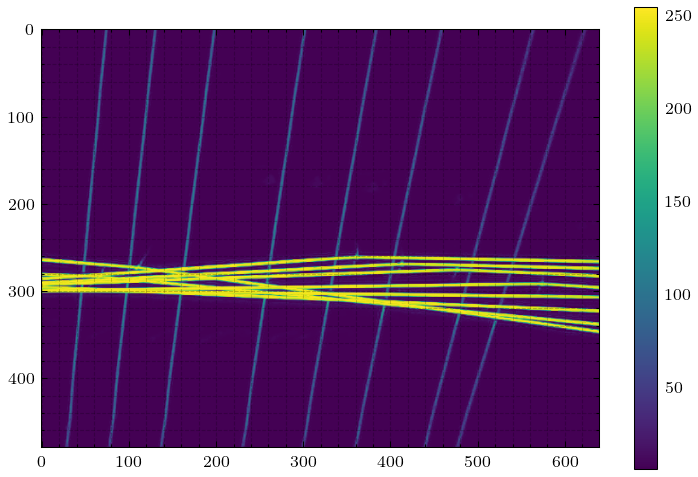

In [16]:
images = np.array([cv2.imread(f"out/{i}_1300_original.png", cv2.IMREAD_GRAYSCALE) for i in range(1, 9)])
image_max = np.maximum.reduce(images)
plt.imshow(image_max)
plt.colorbar()

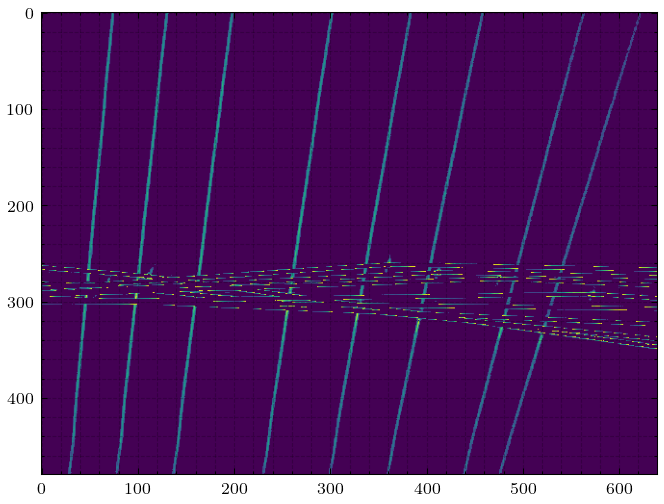

In [17]:
image_filter = np.where((image_max > 30) & (image_max < 180), image_max, np.zeros_like(image_max))
plt.imshow(image_filter)

In [18]:
def fit_2d_polynomial_and_calibrate(image):
    """
    Аппроксимирует двумерный полином второго порядка по ненулевым пикселям
    """
    # 1. Находим координаты ненулевых пикселей
    nonzero_indices = np.nonzero(image)
    y_coords, x_coords = nonzero_indices
    z_values = image[y_coords, x_coords]
    
    # 2. Создаем матрицу признаков для полинома второго порядка
    # Для формулы: a₀ + a₁x + a₂y + a₃x² + a₄xy + a₅y²
    X = np.column_stack([
        np.ones_like(x_coords),  # a₀
        x_coords,                # a₁
        y_coords,                # a₂
        x_coords**2,             # a₃
        x_coords * y_coords,     # a₄
        y_coords**2              # a₅
    ])
    
    # 3. Решаем систему линейных уравнений методом наименьших квадратов
    coefficients, _, _, _ = np.linalg.lstsq(X, z_values, rcond=None)
    
    # 4. Создаем сетку координат для всего изображения
    height, width = image.shape
    y_grid, x_grid = np.mgrid[0:height, 0:width]
    
    # 5. Вычисляем значения полинома для каждого пикселя изображения
    poly_surface = (
        coefficients[0] + 
        coefficients[1] * x_grid + 
        coefficients[2] * y_grid + 
        coefficients[3] * x_grid**2 + 
        coefficients[4] * x_grid * y_grid + 
        coefficients[5] * y_grid**2
    )
    
    return coefficients, poly_surface

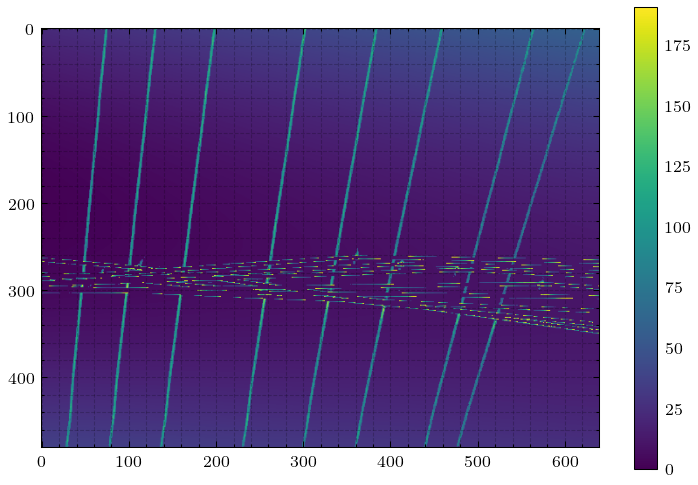

In [19]:
coeffs, poly_surface = fit_2d_polynomial_and_calibrate(image_filter)

plt.imshow(image_filter - poly_surface + poly_surface.max())
plt.colorbar()

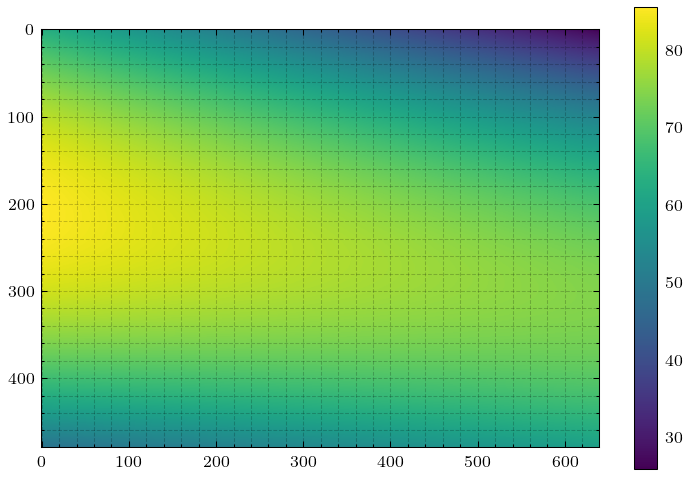

In [20]:
plt.imshow(poly_surface)
plt.colorbar()